In [70]:
import MetaTrader5 as mt5
import pandas as pd
import pandas_ta as ta
import talib
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Connecting to TickMill MetaTrader5 Account
my_account = '##########'
my_password = '#############'
server = "Tickmill-Demo"

mt5.initialize(login=my_account, server=server,password=my_password)
mt5.initialize()

True

In [5]:
def MT5_DATA(symbol, TIME_FRAME='H1', bars=99999):
    TIMEFRAMES = {
        'D1': [mt5.TIMEFRAME_D1, 1440],
        'H12': [mt5.TIMEFRAME_H12, 720],
        'H8': [mt5.TIMEFRAME_H8, 480],
        'H6': [mt5.TIMEFRAME_H6, 360],
        'H4': [mt5.TIMEFRAME_H4, 240],
        'H3': [mt5.TIMEFRAME_H3, 180],
        'H2': [mt5.TIMEFRAME_H2, 120],
        'H1': [mt5.TIMEFRAME_H1, 60],
        'M30': [mt5.TIMEFRAME_M30, 30],
        'M20': [mt5.TIMEFRAME_M20, 20],
        'M15': [mt5.TIMEFRAME_M15, 15],
        'M12': [mt5.TIMEFRAME_M12, 12],
        'M10': [mt5.TIMEFRAME_M10, 10],
        'M6': [mt5.TIMEFRAME_M6, 6],
        'M5': [mt5.TIMEFRAME_M5, 5],
        'M4': [mt5.TIMEFRAME_M4, 4],
        'M3': [mt5.TIMEFRAME_M3, 3],
        'M2': [mt5.TIMEFRAME_M2, 2],
        'M1': [mt5.TIMEFRAME_M1, 1]
    }
    
    df = pd.DataFrame(mt5.copy_rates_from_pos(symbol, TIMEFRAMES.get(TIME_FRAME)[0],0, bars))
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace = True)
    df['time'] = df.index
    df = df[:-1]
    #df = df[str(df.index.year[-1] - 3):]
    df = df[['time','open','high','low','close','spread']]
    #df = df[['open','high','low','close']]
    
    df['spread'] = df['spread'] * mt5.symbol_info(symbol).point
    
    if TIME_FRAME=='D1':
        return df
    
    else: return df['2019':]

In [78]:
def walk_forward_split(df , split_ref_block_size = 7, test_size = 0.25):
    block_size = int(len(df.values) / split_ref_block_size)
    size = int(block_size*test_size)
    return [ ( df.iloc[n-block_size:n][:-size] , df.iloc[n-block_size:n][-size:] ) for n in range(block_size, len(df.values), size)]

In [6]:
def Vectorized_Backtest(df, vol):
    to_backtest_df = df[((df['signal'])!='0') | (df['signal_exit']!='0')]

    buy_entries = to_backtest_df[to_backtest_df['signal']=='buy']
    buy_entries = buy_entries[['Time','close','signal','spread']]
    buy_entries.columns = ['Time','open_price','signal','spread']
    buy_entries['open_datetime'] = buy_entries['Time']
    buy_entries['open_price'] = buy_entries['open_price'] + buy_entries['spread'] # The open price is considering the spread

    exit_buy_entries = to_backtest_df[to_backtest_df['signal_exit']=='buy_exit']
    exit_buy_entries = exit_buy_entries[['Time','close','signal_exit','spread']]
    exit_buy_entries.columns = ['Time', 'close_price','signal_exit','spread']
    exit_buy_entries['close_datetime'] = exit_buy_entries['Time']
    exit_buy_entries['close_price'] = exit_buy_entries['close_price'] - exit_buy_entries['spread']  # The close price is considering the spread


    sell_entries = to_backtest_df[to_backtest_df['signal']=='sell']
    sell_entries = sell_entries[['Time','close','signal','spread']]
    sell_entries.columns = ['Time','open_price','signal','spread']
    sell_entries['open_datetime'] = sell_entries['Time']
    sell_entries['open_price'] = sell_entries['open_price'] - sell_entries['spread'] # The open price is considering the spread


    exit_sell_entries = to_backtest_df[to_backtest_df['signal_exit']=='sell_exit']
    exit_sell_entries = exit_sell_entries[['Time','close','signal_exit','spread']]
    exit_sell_entries.columns = ['Time', 'close_price','signal_exit','spread']
    exit_sell_entries['close_datetime'] = exit_sell_entries['Time']
    exit_sell_entries['close_price'] = exit_sell_entries['close_price'] + exit_sell_entries['spread'] # The close price is considering the spread

    long_trades = pd.merge_asof(buy_entries, exit_buy_entries, direction="forward", on='Time').drop_duplicates(['close_datetime'], keep='first')
    short_trades = pd.merge_asof(sell_entries, exit_sell_entries, direction="forward", on='Time').drop_duplicates(['close_datetime'], keep='first')

    main_backtest = pd.concat([long_trades, short_trades])
    main_backtest = main_backtest.sort_values(by=['Time'], ascending=True)
    main_backtest['profit'] = (main_backtest['close_price'] - main_backtest['open_price']) * vol
    main_backtest['profit'] = np.where( main_backtest['signal']=='sell', main_backtest['profit'] * -1 , main_backtest['profit'])

    main_backtest = main_backtest[['open_datetime','open_price','signal','close_datetime','close_price','profit']]
    main_backtest.columns = ['open_datetime','open_price','order_type','close_datetime','close_price','profit']
    
    counter_winners = 0
    counter_losses = 0

    winner_streaks = []
    losses_streaks = []

    for n in [1 if n>0 else -1 for n in main_backtest['profit'].values]:
        if n == 1:
           counter_losses = 0
           counter_winners = counter_winners + 1

        elif n == -1:
           counter_winners = 0
           counter_losses = counter_losses + 1

        winner_streaks.append(counter_winners)
        losses_streaks.append(counter_losses)
    
    main_backtest['Win_streak'] = winner_streaks
    main_backtest['Loss_streak'] = losses_streaks
    
    return main_backtest

In [74]:
def drawdown(profits):
   # ========================================================================================== #
   #                                      Drawdown Calculation                                  #       
   # ========================================================================================== #
    df = pd.DataFrame(profits)
    df.columns = ['profit']
    
    df['pnl'] = df['profit'].cumsum()
    
    max_value = 0
    max_ = []

    for n in df['pnl'].values:
        if n > max_value:
            max_value = n

        max_.append(max_value)     

    df['high_account'] = max_
    df['$drawdown'] =  df['high_account'] - df['pnl']
    df['%drawdown'] = (df['high_account'] - df['pnl'])/df['high_account']
    
    mean_dd = df['$drawdown'].mean()
    max_dd = df['$drawdown'].max()
    
    return mean_dd, max_dd

In [8]:
def custom_macd(fast, slow, signal, ma_type = 'ema'):
    if ma_type == 'sma':
        MACD = ta.sma(df['close'], fast) - ta.sma(df['close'], slow)
        Signal = ta.sma(MACD, signal)
        Histogram = MACD - Signal
    
    if ma_type == 'ema':
        MACD = ta.ema(df['close'], fast) - ta.ema(df['close'], slow)
        Signal = ta.ema(MACD, signal)
        Histogram = MACD - Signal
    
    if ma_type == 'dema':
        MACD = ta.dema(df['close'], fast) - ta.dema(df['close'], slow)
        Signal = ta.dema(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'tema':
        MACD = ta.tema(df['close'], fast) - ta.tema(df['close'], slow)
        Signal = ta.tema(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'trima':
        MACD = ta.trima(df['close'], fast) - ta.trima(df['close'], slow)
        Signal = ta.trima(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'hma':
        MACD = ta.hma(df['close'], fast) - ta.hma(df['close'], slow)
        Signal = ta.hma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'zlma':
        MACD = ta.zlma(df['close'], fast) - ta.zlma(df['close'], slow)
        Signal = ta.zlma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'rma':
        MACD = ta.rma(df['close'], fast) - ta.rma(df['close'], slow)
        Signal = ta.rma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'wma':
        MACD = ta.wma(df['close'], fast) - ta.wma(df['close'], slow)
        Signal = ta.wma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'sinwma':
        MACD = ta.sinwma(df['close'], fast) - ta.sinwma(df['close'], slow)
        Signal = ta.sinwma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'swma':
        MACD = ta.swma(df['close'], fast) - ta.swma(df['close'], slow)
        Signal = ta.swma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'kama':
        MACD = ta.kama(df['close'], fast) - ta.kama(df['close'], slow)
        Signal = ta.kama(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'linreg':
        MACD = ta.linreg(df['close'], fast) - ta.linreg(df['close'], slow)
        Signal = ta.linreg(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 't3':
        MACD = ta.t3(df['close'], fast) - ta.t3(df['close'], slow)
        Signal = ta.t3(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'hwma':
        MACD = ta.hwma(df['close'], fast) - ta.hwma(df['close'], slow)
        Signal = ta.hwma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'fwma':
        MACD = ta.fwma(df['close'], fast) - ta.fwma(df['close'], slow)
        Signal = ta.fwma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'pwma':
        MACD = ta.pwma(df['close'], fast) - ta.pwma(df['close'], slow)
        Signal = ta.pwma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'jma':
        MACD = ta.jma(df['close'], fast) - ta.jma(df['close'], slow)
        Signal = ta.jma(MACD, signal)
        Histogram = MACD - Signal
        
    if ma_type == 'ssf':
        MACD = ta.ssf(df['close'], fast) - ta.ssf(df['close'], slow)
        Signal = ta.ssf(MACD, signal)
        Histogram = MACD - Signal

    dF = pd.DataFrame()
    dF['MACD'] = MACD
    dF['Histogram'] = Histogram 
    dF['Signal'] = Signal
    
    return dF[['MACD','Histogram','Signal']]

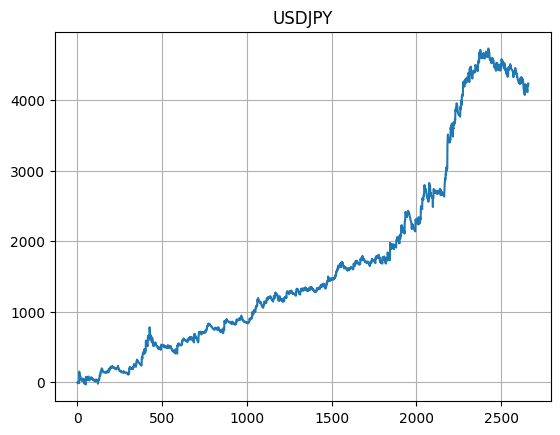

0:00:01.179004


,open_datetime,open_price,order_type,close_datetime,close_price,profit,Win_streak,Loss_streak
0,2019-07-29 11:15:00,108.673,buy,2019-07-29 12:30:00,108.610,-4.977,0,1
0,2019-07-29 12:30:00,108.610,sell,2019-07-29 13:15:00,108.664,-4.266,0,2
1,2019-07-29 13:15:00,108.664,buy,2019-07-29 14:00:00,108.606,-4.582,0,3
1,2019-07-29 14:00:00,108.606,sell,2019-07-29 14:45:00,108.641,-2.765,0,4
3,2019-07-29 14:45:00,108.641,buy,2019-07-30 04:15:00,108.805,12.956,1,0
...,...,...,...,...,...,...,...,...
7960,2023-07-31 10:00:00,142.079,buy,2023-07-31 17:45:00,142.055,-1.896,0,1
7970,2023-08-01 10:30:00,142.730,buy,2023-08-01 12:30:00,142.625,-8.295,0,2
7361,2023-08-01 12:30:00,142.625,sell,2023-08-01 13:15:00,142.737,-8.848,0,3
7977,2023-08-01 13:15:00,142.737,buy,2023-08-02 00:15:00,143.170,34.207,1,0


In [58]:
symbol = 'USDJPY'
TF = 'M15'

df = MT5_DATA(symbol, TIME_FRAME=TF, bars=99999) 
df.columns = ['Time','open','high','low','close','spread']

start_time = datetime.datetime.now()

vol = 79  #estimated for lot size 0.1

fast = 6
slow = 13
signal = 4

ma_len = 35

df['Hour'] = df.index.hour
df[['fast','histogram','slow']] = custom_macd(fast, slow, signal, ma_type = 'ema')
df['hma'] = ta.ema(df['close'], ma_len)
df.dropna(inplace=True)


sell_condition = ((df['fast']<df['slow']) & 
                  (df['close']<df['hma']) & 
                  (df['Hour']>=10) & (df['Hour']<=15))
        
buy_condition = ((df['fast']>df['slow']) & 
                 (df['close']>df['hma']) & 
                 (df['Hour']>=10) & (df['Hour']<=15))


sell_exit_condition = (df['fast']>df['slow']) & (df['close']>df['hma'])

buy_exit_condition = (df['fast']<df['slow']) & (df['close']<df['hma'])


df['signal'] = np.where(sell_condition, 'sell', 
               np.where(buy_condition , 'buy', 0))

df['signal_exit'] = np.where(buy_exit_condition, 'buy_exit',
                    np.where(sell_exit_condition, 'sell_exit', 0))


main_backtest = Vectorized_Backtest(df, vol)

plt.plot(np.cumsum(main_backtest['profit'].values))
plt.title(f'{symbol}')
plt.grid()
plt.show()

end_time = datetime.datetime.now() - start_time
print(end_time)

main_backtest

In [95]:
# Metrics
avg_drawdown, max_drawdown = drawdown(main_backtest['profit'].dropna().values)
percentage_winner_profits = len([n for n in main_backtest['profit'].values if n>0])/len([n for n in main_backtest['profit'].values])
percentage_losser_profits = len([n for n in main_backtest['profit'].values if n<0])/len([n for n in main_backtest['profit'].values])
average_winner_trades = np.mean([n for n in main_backtest['profit'].values if n>0])
average_losser_trades = np.abs(np.mean([n for n in main_backtest['profit'].values if n<0]))
Winner_trades_over_Losser_trades = average_winner_trades/average_losser_trades
Average_trade_duration = (main_backtest['close_datetime'] - main_backtest['open_datetime']).mean()

print(f"""
Metrics Trading Strategy

Average Drawdown: {np.round(avg_drawdown, 2)} 
Max Drawdown: {np.round(max_drawdown, 2)}

Percentage Winner Profits: {np.round(percentage_winner_profits * 100, 2)}%
Percentage Losser Profits: {np.round(percentage_losser_profits * 100, 2)}%

Average Winner Trades: {np.round(average_winner_trades, 2)}
Average Losser Trades: {np.round(average_losser_trades, 2)}

Winner Trades Over Losser Trades: {np.round(Winner_trades_over_Losser_trades, 2)}

Average Trade Duration: {Average_trade_duration}""")


Metrics Trading Strategy

Average Drawdown: 102.15 
Max Drawdown: 658.7

Percentage Winner Profits: 29.75%
Percentage Losser Profits: 70.02%

Average Winner Trades: 24.06
Average Losser Trades: 7.95

Winner Trades Over Losser Trades: 3.03

Average Trade Duration: 0 days 05:17:55.535512965


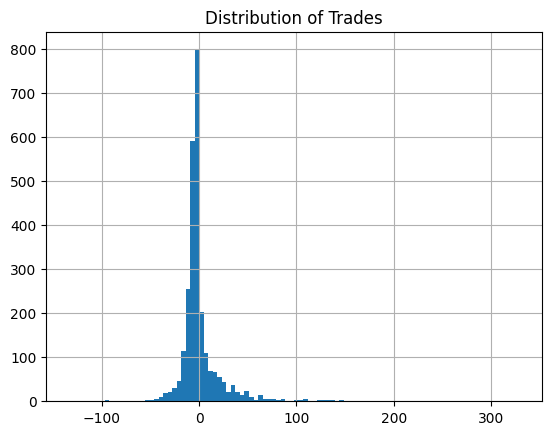

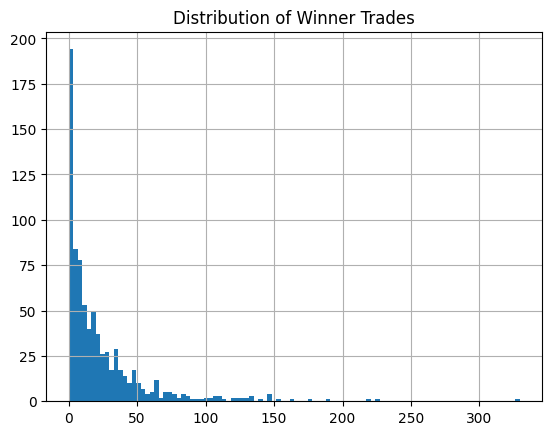

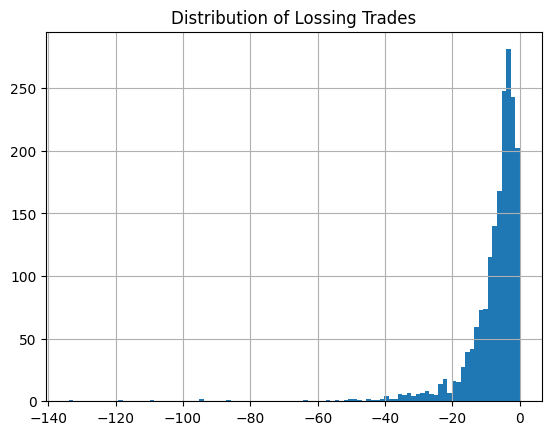

In [28]:
main_backtest['profit'].hist(bins = 100)
plt.title('Distribution of Trades')
plt.show()

main_backtest[main_backtest['profit']>0]['profit'].hist(bins = 100)
plt.title('Distribution of Winner Trades')
plt.show()

main_backtest[main_backtest['profit']<0]['profit'].hist(bins = 100)
plt.title('Distribution of Lossing Trades')
plt.show()

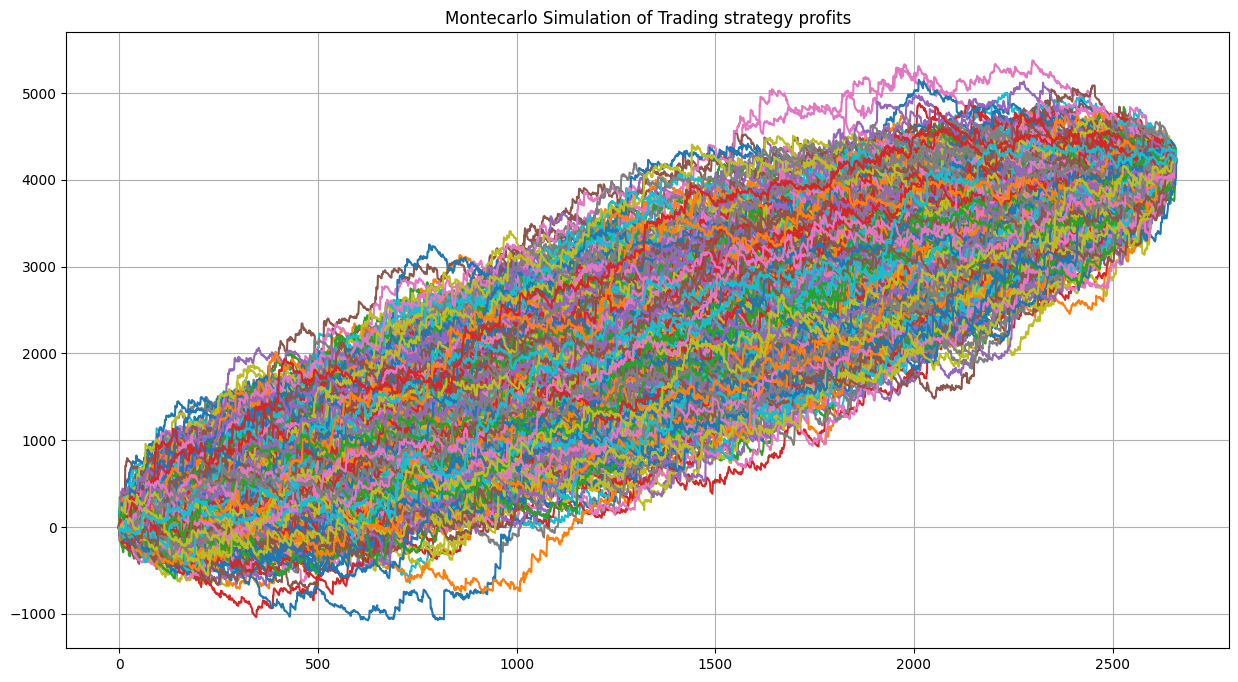

0:15:02.392774


In [72]:
profits = np.array(main_backtest['profit'].dropna().values)
montecarlo_simulations = []
simulations = 1000

for n in range(simulations):
    np.random.shuffle(profits)
    curve = np.array(pd.DataFrame(profits).cumsum().values)
    montecarlo_simulations.append(curve)

montecarlo_simulations = np.array(montecarlo_simulations)

random_walks = pd.DataFrame()

for n in range(len(montecarlo_simulations)):
    random_walks[f'Sim_{n}'] = montecarlo_simulations[n].reshape(-1)
    
random_walks.plot(legend=None, figsize=(15, 8))
plt.title('Montecarlo Simulation of Trading strategy profits')
plt.grid()
plt.show()

end_time = datetime.datetime.now() - start_time
print(end_time)

In [73]:
random_walks

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,...,Sim_990,Sim_991,Sim_992,Sim_993,Sim_994,Sim_995,Sim_996,Sim_997,Sim_998,Sim_999
0,103.569,-14.536,-3.318,23.937,21.567,-8.295,-0.632,-1.264,-0.711,2.449,...,-7.742,-9.638,-11.613,20.382,-2.133,-1.185,-2.607,-3.318,-18.091,-6.162
1,121.423,-17.854,-11.534,22.752,1.264,-14.536,4.266,-8.216,-0.079,-4.740,...,-10.902,-11.297,87.769,15.247,-3.792,-7.426,-6.873,-12.166,-11.376,-17.459
2,117.631,-26.860,-22.910,18.407,3.239,-24.964,4.582,-11.139,-17.775,-7.821,...,-13.272,-18.249,86.505,90.850,-6.162,4.108,-6.715,-10.981,-12.956,-19.118
3,106.255,-16.432,-22.752,11.060,1.738,-33.812,-7.031,-13.983,-20.935,-13.430,...,-13.114,-23.147,171.825,81.923,-9.638,-0.395,-19.671,-17.222,-17.380,-28.361
4,117.078,-24.727,-25.675,47.716,-10.191,-33.101,-10.823,-17.933,-25.596,-17.538,...,-20.382,0.790,170.561,80.264,-14.852,-32.706,26.781,-23.305,-26.386,-32.864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,4112.582,4235.032,4254.861,4205.486,4235.348,4259.838,4132.174,4265.526,4245.776,4210.068,...,4034.609,4254.308,4248.857,4224.209,4284.407,4187.158,4213.307,4256.678,4238.350,4224.604
2657,4114.715,4209.278,4250.042,4248.304,4234.716,4257.626,4187.158,4257.231,4244.196,4215.203,...,4018.493,4245.223,4237.639,4221.918,4283.222,4243.011,4210.858,4251.148,4238.034,4259.838
2658,4108.079,4240.088,4237.481,4247.356,4243.722,4250.121,4190.792,4255.572,4261.655,4200.114,...,4015.017,4237.718,4237.560,4220.259,4270.424,4243.169,4212.438,4242.774,4234.795,4255.809
2659,4163.932,4240.720,4231.398,4245.618,4233.294,4245.618,4238.429,4233.610,4248.146,4195.769,...,4012.884,4234.953,4232.741,4236.059,4265.447,4237.797,4235.901,4234.479,4231.082,4236.770
